In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# %cd '/content/gdrive/MyDrive/Virginia Tech /Fall 2022/Codes from GPU/MURI Aug17 Thin Plate'

In [4]:
# !pip install smt

In [5]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
           
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# # Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None].reshape(-1,1) # NT x 1
y = YY.flatten()[:,None].reshape(-1,1) # NT x 1
t = TT.flatten()[:,None].reshape(-1,1) # NT x 1

u_true = UU.flatten()[:,None].reshape(-1,1) # NT x 1
v_true = VV.flatten()[:,None].reshape(-1,1) # NT x 1
p_true = PP.flatten()[:,None].reshape(-1,1) # NT x 1

label = "3D_NS_stan"

loss_thresh = 10000

N_train = x.shape[0]
xyt = np.hstack((x,y,t))

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

# xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
np.random.seed(1234)
idx = np.random.choice(N_train, 5000, replace=False)
u_true_test = u_true[idx,:]
v_true_test = v_true[idx,:]
p_true_test = p_true[idx,:]

u_true_norm = np.linalg.norm(u_true,2)
v_true_norm = np.linalg.norm(v_true,2)
p_true_norm = np.linalg.norm(p_true,2)

# u_true_test = torch.from_numpy(u_true_test).float().to(device)
# v_true_test = torch.from_numpy(v_true_test).float().to(device)
# p_true_test = torch.from_numpy(p_true_test).float().to(device)

x_tensor = torch.from_numpy(x[idx,:]).float().to(device)
y_tensor = torch.from_numpy(y[idx,:]).float().to(device)
t_tensor = torch.from_numpy(t[idx,:]).float().to(device)

In [6]:

# x = np.linspace(1,8,100).reshape(-1,1)
# y = np.linspace(-2,2,100).reshape(-1,1)
# t = np.linspace(0,20,100).reshape(-1,1)

# X,Y,T = np.meshgrid(x,y,t)

# X = X.flatten('F').reshape(-1,1)
# Y = Y.flatten('F').reshape(-1,1)
# T = T.flatten('F').reshape(-1,1)
  
# xyt = np.hstack((X,Y,T))

# initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

# DBC_pts = (Y == 0).reshape(-1,)


# NBC_pts_x0 = (X == 0).reshape(-1,)
# NBC_pts_x1 = (X == 1).reshape(-1,)

# NBC_pts_y0 = (Y == 0).reshape(-1,)
# NBC_pts_y1 = (Y == 1).reshape(-1,)

# xyt_initial = xyt[initial_pts,:]
# xyt_DBC = xyt[DBC_pts,:]

# xyt_NBC_x0 = xyt[NBC_pts_x0,:]
# xyt_NBC_x1 = xyt[NBC_pts_x1,:]

# #xyt_NBC_y0 = xyt[NBC_pts_y0,:]
# xyt_NBC_y1 = xyt[NBC_pts_y1,:]

# u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
# u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

# xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
# #xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
# xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
# #xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
# xyt_NBC_y = np.vstack((xyt_NBC_y1))

# u_I_DBC = np.vstack((u_initial,u_DBC))


# lb_xyt = xyt[0]
# ub_xyt = xyt[-1]

In [7]:
# fea_data = scipy.io.loadmat('./../3D_HTTP_FEA.mat')
# xy = fea_data['xy']
# t = fea_data['t']/3000
# xyt = np.zeros((497*101,3))
# u_true = np.ones((497*101,1))


# for i in range(101):
#     t_temp = t[0,i]*np.ones((497,1))
#     xyt[497*i:497*(i+1)] = np.hstack((xy,t_temp))
#     u_true[497*i:497*(i+1)] = fea_data['u'][:,i].reshape(-1,1)
#     #print(i)
# #print(xyt)

# xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
# u_true_norm = np.linalg.norm(u_true,2)

In [8]:
def trainingdata(N_T,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    idx = np.random.choice(N_train, N_T, replace=False)
    x_train = x[idx,:]
    y_train = y[idx,:]
    t_train = t[idx,:]
    u_train = u_true[idx,:]
    v_train = v_true[idx,:]
    
    return x_train,y_train,t_train,u_train,v_train

In [9]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.lambda1 = Parameter(torch.tensor(0.0))
        self.lambda1.requires_grad = True
        
        self.lambda2 = Parameter(torch.tensor(0.0))
        self.lambda2.requires_grad = True
    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt- lbxyt)/(ubxyt - lbxyt)-1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_uv(self,x_train,y_train,t_train,u_train,v_train):
        x1 = x_train.clone()
        x1.requires_grad = True
        
        y1 = y_train.clone()
        y1.requires_grad = True
        
        t1 = t_train.clone()
        t1.requires_grad = True
        
#         print(torch.cat((x1,y1,t1),dim=1).shape)
        psi_p = self.forward(torch.cat((x1,y1,t1),dim =1))
        
        psi = psi_p[:,0:1]
        
#         print(psi.shape)
        psi_x = autograd.grad(psi,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        psi_y = autograd.grad(psi,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
                
        loss_u = self.loss_function(psi_y,u_train)
        loss_v = self.loss_function(-1*psi_x,v_train)
                
        return loss_u + loss_v
    
    def loss_PDE(self, x_train,y_train,t_train,fg_hat):
        
        x1 = x_train.clone()
        x1.requires_grad = True
        
        y1 = y_train.clone()
        y1.requires_grad = True
        
        t1 = t_train.clone()
        t1.requires_grad = True
        
        psi_p = self.forward(torch.cat((x1,y1,t1),dim =1))
        psi = psi_p[:,0:1]
        p = psi_p[:,1:2]
        
        
        u = autograd.grad(psi,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v = -1*autograd.grad(psi,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        #---------------------------------------------------------------------------------------------------------------
        u_t = autograd.grad(u,t1,torch.ones([t1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_x = autograd.grad(u,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        u_xx = autograd.grad(u_x,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
                
        u_y = autograd.grad(u,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        u_yy = autograd.grad(u_y,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        #---------------------------------------------------------------------------------
        
        v_t = autograd.grad(v,t1,torch.ones([t1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        v_x = autograd.grad(v,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_xx = autograd.grad(v_x,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
                
        v_y = autograd.grad(v,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_yy = autograd.grad(v_y,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        #------------------------------------------------------------------------------------
        p_x = autograd.grad(p,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        p_y = autograd.grad(p,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
            
            

        f = u_t + self.lambda1*(u*u_x + v*u_y) + p_x - self.lambda2*(u_xx + u_yy)
        g = v_t + self.lambda1*(u*v_x + v*v_y) + p_y - self.lambda2*(v_xx + v_yy)
        
        loss_f = self.loss_function(f,fg_hat)
        loss_g = self.loss_function(g,fg_hat)
                
        return loss_f + loss_g
    
    def loss(self,x_train,y_train,t_train,u_train,v_train,fg_hat):

        loss_uv = self.loss_uv(x_train,y_train,t_train,u_train,v_train)
        loss_fg = self.loss_PDE(x_train,y_train,t_train,fg_hat)
        loss_val = loss_uv + loss_fg
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
       
    'test neural network'
    def test(self):
        x1 = x_tensor.clone()
        x1.requires_grad = True
        
        y1 = y_tensor.clone()
        y1.requires_grad = True
        
        t1 = t_tensor.clone()
        t1.requires_grad = True
        
        psi_p_pred = self.forward(torch.cat((x1,y1,t1),dim =1))
        psi = psi_p_pred[:,0:1]
        p_pred = psi_p_pred[:,1:2]
        
        u_pred = autograd.grad(psi,y1,torch.ones([y1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_pred = -1*autograd.grad(psi,x1,torch.ones([x1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
   
        u_pred = u_pred.cpu().detach().numpy()
        v_pred = v_pred.cpu().detach().numpy()
        p_pred = p_pred.cpu().detach().numpy()
    
        return u_pred,v_pred,p_pred

    def test_loss(self):
        u_pred,v_pred,p_pred = self.test()
        
        test_mse_u = np.mean(np.square(u_pred.reshape(-1,1) - u_true_test.reshape(-1,1)))
        test_re_u = np.linalg.norm(u_pred.reshape(-1,1) - u_true_test.reshape(-1,1),2)/u_true_norm
        
        test_mse_v = np.mean(np.square(v_pred.reshape(-1,1) - v_true_test.reshape(-1,1)))
        test_re_v = np.linalg.norm(v_pred.reshape(-1,1) - v_true_test.reshape(-1,1),2)/v_true_norm
        
        test_mse_p = np.mean(np.square(p_pred.reshape(-1,1) - p_true_test.reshape(-1,1)))
        test_re_p = np.linalg.norm(p_pred.reshape(-1,1) - p_true_test.reshape(-1,1),2)/p_true_norm
        
        return test_mse_u, test_re_u, test_mse_v, test_re_v, test_mse_p, test_re_p 

In [10]:
def train_step(x_train,y_train,t_train,u_train,v_train,fg_hat,seed):    
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(x_train,y_train,t_train,u_train,v_train,fg_hat)
        loss.backward()
        
        return loss

    optimizer.step(closure)

In [11]:
def data_update(loss_np,x_train,y_train,t_train):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    lambda1_val.append(PINN.lambda1.cpu().detach().numpy())
    lambda2_val.append(PINN.lambda2.cpu().detach().numpy())
    
    test_mse_u, test_re_u, test_mse_v, test_re_v, test_mse_p, test_re_p = PINN.test_loss()
    
    test_mse_u_loss.append(test_mse_u)
    test_re_u_loss.append(test_re_u)
    
    test_mse_v_loss.append(test_mse_v)
    test_re_v_loss.append(test_re_v)
    
    test_mse_p_loss.append(test_mse_p)
    test_re_p_loss.append(test_re_p)

In [12]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*11)
    start_time = time.time() 
    thresh_flag = 0
    
    x_train,y_train,t_train,u_train,v_train = trainingdata(N_T,(reps)*22)

    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    t_train = torch.from_numpy(t_train).float().to(device)
    u_train = torch.from_numpy(u_train).float().to(device)
    v_train = torch.from_numpy(v_train).float().to(device)
        
    fg_hat = torch.zeros(x_train.shape[0],1).to(device)
    
    for i in range(max_iter):
        train_step(x_train,y_train,t_train,u_train,v_train,fg_hat,i)

        loss_np = PINN.loss(x_train,y_train,t_train,u_train,v_train,fg_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np,x_train,y_train,t_train)
        print(i,"Loss",train_loss[-1], "L1",lambda1_val[-1],"L2",lambda2_val[-1])
        # print(i,"Loss",train_loss[-1],"RE",test_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [13]:
max_reps = 1
max_iter = 1000

train_loss_full = []

test_mse_u_full = []
test_re_u_full = []
test_mse_v_full = []
test_re_v_full = []
test_mse_p_full = []
test_re_p_full = []


beta_full = []
lambda1_full = []
lambda2_full = []

elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 1.0

for reps in range(max_reps):
    print(label)
    train_loss = []
    
    test_mse_u_loss = []
    test_re_u_loss = []
    
    test_mse_v_loss = []
    test_re_v_loss = []
    
    test_mse_p_loss = []
    test_re_p_loss = []
    
    lambda1_val = []
    lambda2_val = []
    beta_val = []

    print(reps)

    torch.manual_seed(reps*36)
    N_T = 5000

    layers = np.array([3,50,50,50,50,2]) #9 hidden layers

    PINN = Sequentialmodel(layers,beta_init)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-8, 
                              tolerance_change = 1e-8, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    nan_flag = train_model(max_iter,reps)


    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    
    test_mse_u_full.append(test_mse_u_loss)
    test_re_u_full.append(test_re_u_loss)
    test_mse_v_full.append(test_mse_v_loss)
    test_re_v_full.append(test_re_v_loss)
    test_mse_p_full.append(test_mse_p_loss)
    test_re_p_full.append(test_re_p_loss)

    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)
    lambda1_full.append(lambda1_val)
    lambda2_full.append(lambda2_val)

    #print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_u": test_mse_u_full,"test_re_u_loss": test_re_u_full,"test_mse_v": test_mse_v_full,"test_re_v_loss": test_re_v_full,"test_mse_p": test_mse_p_full,"test_re_p_loss": test_re_p_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold, "lambda1":lambda1_full,"lambda2":lambda2_full}
savemat(label+'.mat', mdic)

3D_NS_stan
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)
0
0 Loss 0.10068626 L1 0.00802775 L2 -0.0067287567
1 Loss 0.09513332 L1 -0.005040844 L2 -0.0016071522
2 Loss 0.09371072 L1 -0.026520284 L2 -0.00045677263
3 Loss 0.09257895 L1 0.0021382172 L2 0.00085439417
4 Loss 0.09143096 L1 0.07746466 L2 0.0028363497
5 Loss 0.08983109 L1 0.1050835 L2 0.005258222
6 Loss 0.08204637 L1 0.40558124 L2 0.01583911
7 Loss 0.056964204 L1 0.86050296 L2 0.024711141
8 Loss 0.02665618 L1 0.83406 L2 0.013724968
9 Loss 0.019367829 L1 0.86586016 L2 0.015405356
10 Loss 0.014933664 L1 0.8815587 L2 0.015499877
11 Loss 0.012233402 L1 0.9093702 L2 0.016982947
12 Loss 

In [15]:
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
           
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# # Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None].reshape(-1,1) # NT x 1
y = YY.flatten()[:,None].reshape(-1,1) # NT x 1
t = TT.flatten()[:,None].reshape(-1,1) # NT x 1

u_true = UU.flatten()[:,None].reshape(-1,1) # NT x 1
v_true = VV.flatten()[:,None].reshape(-1,1) # NT x 1
p_true = PP.flatten()[:,None].reshape(-1,1) # NT x 1

label = "3D_NS_stan"

loss_thresh = 10000

N_train = x.shape[0]
xyt = np.hstack((x,y,t))

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

# xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
np.random.seed(1234)
idx = np.where(t==5)
idx = idx[0]
u_true_test = u_true[idx,:]
v_true_test = v_true[idx,:]
p_true_test = p_true[idx,:]

u_true_norm = np.linalg.norm(u_true,2)
v_true_norm = np.linalg.norm(v_true,2)
p_true_norm = np.linalg.norm(p_true,2)

# u_true_test = torch.from_numpy(u_true_test).float().to(device)
# v_true_test = torch.from_numpy(v_true_test).float().to(device)
# p_true_test = torch.from_numpy(p_true_test).float().to(device)

x_tensor = torch.from_numpy(x[idx,:]).float().to(device)
y_tensor = torch.from_numpy(y[idx,:]).float().to(device)
t_tensor = torch.from_numpy(t[idx,:]).float().to(device)

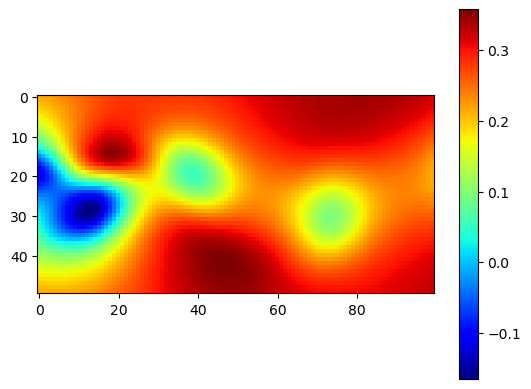

In [16]:
u,v,p = PINN.test()
fig,ax = plt.subplots(1,1)
img = ax.imshow(p.reshape(50,100),cmap = 'jet')
cbar = fig.colorbar(img, ax=ax)

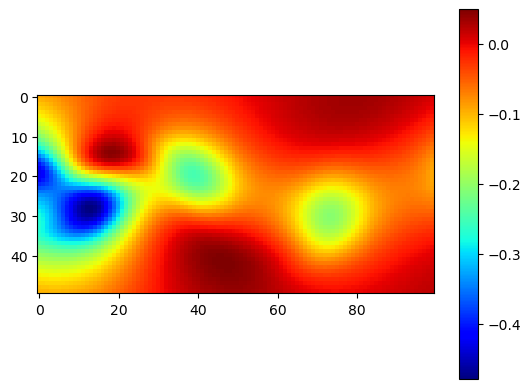

In [19]:
fig,ax = plt.subplots(1,1)
img = ax.imshow(p_true_test.reshape(50,100),cmap = 'jet')
cbar = fig.colorbar(img, ax=ax)